# STL-10 Subset Classification: Logistic Regression & K-Means

**Classes used:** airplane, car, cat, dog, ship

This notebook includes:
1. Preprocessing
2. Feature Extraction
3. Logistic Regression
4. K-Means Classification
5. Optimal number of clusters
6. Visualization
7. Model Comparison


In [10]:
# ================== Cell 1: Import Libraries ==================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, silhouette_score, davies_bouldin_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import seaborn as sns
from torchvision import datasets, transforms
import warnings
import gc
warnings.filterwarnings('ignore')

# 1️⃣ Load STL-10 Binary Data
We use the STL-10 dataset downloaded from Kaggle in binary format. We filter the subset of 5 classes.


In [6]:
# ================== Cell 2: Load STL-10 subset (5 classes) ==================
# --- Target Classes ---
TARGET_CLASSES = [0, 1, 2, 3, 4]
class_names = ['airplane','bird','car','cat','deer']

# --- Preprocessing Transform for torchvision ---
transform = transforms.Compose([
    transforms.Resize((64, 64)),   # Resize smaller for faster processing
    transforms.ToTensor(),
])

# Load STL-10 dataset
train_set = datasets.STL10(root='../../Datasets', split='train', download=True, transform=transform)
test_set = datasets.STL10(root='../../Datasets', split='test', download=True, transform=transform)

# Combine train and test
combined_data = np.concatenate([train_set.data, test_set.data], axis=0)
combined_labels = np.concatenate([train_set.labels, test_set.labels], axis=0)

# Filter target classes
indices = [i for i, label in enumerate(combined_labels) if label in TARGET_CLASSES]
X = combined_data[indices]
y = combined_labels[indices]

# Re-map labels to 0..4
label_map = {old: new for new, old in enumerate(TARGET_CLASSES)}
y = np.array([label_map[label] for label in y])

# Shuffle dataset
idx = np.arange(len(y))
np.random.shuffle(idx)
X = X[idx]
y = y[idx]

# Split 80/20
split = int(0.8 * len(y))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

100%|██████████| 2.64G/2.64G [16:18<00:00, 2.70MB/s]   


Train shape: (5200, 3, 96, 96) Test shape: (1300, 3, 96, 96)


# 2️⃣ Preprocessing
- Resize images to 64x64  
- Histogram Equalization per channel  
- Normalize to [0,1]  
- Flatten for feature matrix  
- StandardScaler



In [7]:
# ===== MODIFIED =====
# ================== Cell 3: Improved Preprocessing ==================
def better_preprocessing(images, size=64):
    """
    معالجة محسنة للصور مع تصحيح تنسيق القنوات
    """
    processed = []
    
    for img in images:
        # الصور من torchvision تأتي كـ (channels, height, width)
        # نحتاج إلى تحويلها إلى (height, width, channels) لـ OpenCV
        if img.shape[0] == 3:  # إذا كانت القنوات أولاً
            img = np.transpose(img, (1, 2, 0))  # تحويل إلى (height, width, channels)
        
        # 1. Resize
        img_resized = cv2.resize(img, (size, size))
        
        # 2. تحويل إلى grayscale (أفضل للتصنيف مع الطرق التقليدية)
        gray = cv2.cvtColor(img_resized, cv2.COLOR_RGB2GRAY)
        
        # 3. تطبيق Gaussian blur لتقليل الضوضاء
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # 4. تطبيع
        normalized = blurred / 255.0
        
        # 5. تسوية (Standardization)
        normalized = (normalized - normalized.mean()) / (normalized.std() + 1e-7)
        
        processed.append(normalized)
    
    return np.array(processed)

# المعالجة المحسنة
print("Applying improved preprocessing...")
Xtr_processed = better_preprocessing(X_train)
Xte_processed = better_preprocessing(X_test)

# تسطيح الصور
Xtr_flat = Xtr_processed.reshape(len(Xtr_processed), -1)
Xte_flat = Xte_processed.reshape(len(Xte_processed), -1)

print(f"After flattening - Train shape: {Xtr_flat.shape}, Test shape: {Xte_flat.shape}")

# Standard Scaling
scaler = StandardScaler()
Xtr_scaled = scaler.fit_transform(Xtr_flat)
Xte_scaled = scaler.transform(Xte_flat)

print("Improved preprocessing done.")
print(f"Features per image: {Xtr_scaled.shape[1]}")

Applying improved preprocessing...
After flattening - Train shape: (5200, 4096), Test shape: (1300, 4096)
Improved preprocessing done.
Features per image: 4096


# 3️⃣ Feature Extraction (PCA)
Reduce dimensions to 200 principal components


In [8]:
# ================== Cell 4: Memory-friendly PCA ==================
from sklearn.decomposition import IncrementalPCA

print("Applying Incremental PCA for dimensionality reduction...")

# استخدام قيمة معقولة لـ n_components
n_components = min(150, Xtr_scaled.shape[0] - 1, Xtr_scaled.shape[1] - 1)
print(f"Selected n_components: {n_components}")

# تحديد batch_size بشكل مناسب
batch_size = max(100, n_components + 1)
print(f"Using batch_size: {batch_size}")

# إنشاء PCA تدريجي
pca = IncrementalPCA(n_components=n_components)

# تدريب PCA على دفعات
n_samples = Xtr_scaled.shape[0]
for i in range(0, n_samples, batch_size):
    batch = Xtr_scaled[i:i + batch_size]
    pca.partial_fit(batch)
    if i % 1000 == 0:
        print(f"  Processed {min(i + batch_size, n_samples)}/{n_samples} samples")

print("\nTransforming training data...")
# تحويل بيانات التدريب على دفعات
Xtr_pca_parts = []
for i in range(0, n_samples, batch_size):
    batch = Xtr_scaled[i:i + batch_size]
    transformed = pca.transform(batch)
    Xtr_pca_parts.append(transformed)
Xtr_pca = np.vstack(Xtr_pca_parts)

print("Transforming test data...")
# تحويل بيانات الاختبار على دفعات
n_test_samples = Xte_scaled.shape[0]
Xte_pca_parts = []
for i in range(0, n_test_samples, batch_size):
    batch = Xte_scaled[i:i + batch_size]
    transformed = pca.transform(batch)
    Xte_pca_parts.append(transformed)
Xte_pca = np.vstack(Xte_pca_parts)

print(f"\nPCA completed successfully!")
print(f"  Original shape: {Xtr_scaled.shape}")
print(f"  Reduced shape: {Xtr_pca.shape}")
print(f"  Explained variance ratio: {np.sum(pca.explained_variance_ratio_):.4f}")

# تحرير الذاكرة
try:
    del Xtr_flat, Xte_flat, Xtr_pca_parts, Xte_pca_parts
except NameError:
    pass
gc.collect()

Applying Incremental PCA for dimensionality reduction...
Selected n_components: 150
Using batch_size: 151
  Processed 151/5200 samples

Transforming training data...
Transforming test data...

PCA completed successfully!
  Original shape: (5200, 4096)
  Reduced shape: (5200, 150)
  Explained variance ratio: 0.8991


73

# 4️⃣ Logistic Regression
Train, predict, evaluate (Accuracy, Confusion Matrix, Classification Report)


In [11]:
# ===== MODIFIED =====
# ================== Cell 5: Optimized Logistic Regression with Grid Search ==================
print("\n" + "="*60)
print("TRAINING OPTIMIZED LOGISTIC REGRESSION")
print("="*60)

# تعريف النموذج الأساسي
log_clf = LogisticRegression(max_iter=1000, random_state=42)

# Grid Search لتحسين المعاملات
print("\nPerforming Grid Search for best parameters...")
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'saga'],
    'class_weight': [None, 'balanced']
}

# إذا كان عدد العينات كبير، استخدم RandomizedSearch بدلاً من GridSearch
from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(
    log_clf, 
    param_grid, 
    cv=3,  # تقليل cv لتسريع العملية
    scoring='accuracy', 
    n_iter=10,  # عدد التوليفات العشوائية
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(Xtr_pca, y_train)

print(f"\nBest parameters: {random_search.best_params_}")
print(f"Best cross-validation accuracy: {random_search.best_score_:.4f}")

# استخدام أفضل نموذج
best_log_clf = random_search.best_estimator_

# التدريب النهائي
best_log_clf.fit(Xtr_pca, y_train)
y_pred_log = best_log_clf.predict(Xte_pca)
acc_log = accuracy_score(y_test, y_pred_log)

print("\n" + "="*60)
print(f"Optimized Logistic Regression Accuracy: {acc_log:.4f}")
print("="*60)

# تقرير مفصل
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred_log, target_names=class_names))

cm_log = confusion_matrix(y_test, y_pred_log)

# عرض معاملات النموذج إذا أردت
print(f"\nNumber of features: {best_log_clf.coef_.shape[1]}")
print(f"Number of classes: {best_log_clf.coef_.shape[0]}")


TRAINING OPTIMIZED LOGISTIC REGRESSION

Performing Grid Search for best parameters...
Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best parameters: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.01}
Best cross-validation accuracy: 0.4117

Optimized Logistic Regression Accuracy: 0.4438

Detailed Classification Report:
              precision    recall  f1-score   support

    airplane       0.43      0.44      0.44       252
        bird       0.39      0.36      0.38       253
         car       0.58      0.77      0.66       271
         cat       0.37      0.29      0.33       257
        deer       0.37      0.34      0.35       267

    accuracy                           0.44      1300
   macro avg       0.43      0.44      0.43      1300
weighted avg       0.43      0.44      0.43      1300


Number of features: 150
Number of classes: 5


# 5️⃣ K-Means Classification
- Determine optimal number of clusters (silhouette)  
- Map clusters to labels  
- Evaluate on test set


In [18]:
# ===== MODIFIED =====
# ================== Cell 6: Improved K-Means as Classifier ==================
print("\n" + "="*60)
print("K-MEANS AS CLASSIFIER - IMPROVED VERSION")
print("="*60)

# 1. تحديد العدد الأمثل للمجموعات باستخدام معيارين مختلفين
print("\n1. Determining optimal number of clusters...")
sil_scores = []
db_scores = []
K_range = range(2, 15)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(Xtr_pca)
    
    # Silhouette Score (كلما زاد كان أفضل)
    sil_scores.append(silhouette_score(Xtr_pca, labels))
    
    # Davies-Bouldin Score (كلما قل كان أفضل)
    db_scores.append(davies_bouldin_score(Xtr_pca, labels))

# العثور على القيم المثلى
optimal_k_sil = K_range[np.argmax(sil_scores)]
optimal_k_db = K_range[np.argmin(db_scores)]

print(f"   - Optimal K (Silhouette): {optimal_k_sil}")
print(f"   - Optimal K (Davies-Bouldin): {optimal_k_db}")

# اختيار K بناءً على القيمتين مع ضمان أنه على الأقل 5 (عدد الفئات)
optimal_k = max(5, min(optimal_k_sil, optimal_k_db))
print(f"   - Selected K: {optimal_k}")

# 2. دالة محسنة لتعيين المجموعات للفئات
def assign_clusters_to_labels_improved(clusters, true_labels, n_clusters):
    """
    تعيين محسّن للمجموعات إلى الفئات
    """
    cluster_to_label = {}
    cluster_stats = {}
    
    for c in range(n_clusters):
        # الحصول على العينات في هذه المجموعة
        idx = np.where(clusters == c)[0]
        
        if len(idx) > 0:
            # حساب نسبة كل فئة في المجموعة
            label_counts = np.bincount(true_labels[idx], minlength=5)
            total = len(idx)
            
            # العثور على الفئة الأكثر شيوعًا
            most_common = np.argmax(label_counts)
            max_count = label_counts[most_common]
            percentage = max_count / total
            
            # تعيين المجموعة للفئة إذا كانت النسبة عالية بما يكفي
            if percentage > 0.4:  # عتبة 40%
                cluster_to_label[c] = most_common
                cluster_stats[c] = {
                    'assigned_label': most_common,
                    'confidence': percentage,
                    'total_samples': total,
                    'distribution': label_counts / total
                }
            else:
                # إذا كان التوزيع متساويًا، نأخذ الفئة الأكثر شيوعًا مع تحذير
                cluster_to_label[c] = most_common
                cluster_stats[c] = {
                    'assigned_label': most_common,
                    'confidence': percentage,
                    'total_samples': total,
                    'distribution': label_counts / total,
                    'warning': 'Low confidence assignment'
                }
                print(f"   Warning: Cluster {c} is mixed (confidence: {percentage:.2f}). Assigning to class {most_common}")
        else:
            cluster_to_label[c] = -1  # مجموعة فارغة
            cluster_stats[c] = {
                'assigned_label': -1,
                'confidence': 0,
                'total_samples': 0,
                'distribution': np.zeros(5)
            }
    
    return cluster_to_label, cluster_stats

# 3. تدريب K-Means
print("\n2. Training K-Means...")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, verbose=0)
clusters_train = kmeans.fit_predict(Xtr_pca)

# تعيين المجموعات للفئات
cluster_to_label, cluster_stats = assign_clusters_to_labels_improved(clusters_train, y_train, optimal_k)

# 4. التنبؤ على بيانات الاختبار
print("\n3. Predicting on test data...")
clusters_test = kmeans.predict(Xte_pca)
y_pred_km = np.array([cluster_to_label.get(c, 0) for c in clusters_test])

# 5. حساب الدقة
valid_indices = np.array([i for i, label in enumerate(y_pred_km) if label != -1])
if len(valid_indices) > 0:
    acc_km = accuracy_score(y_test[valid_indices], y_pred_km[valid_indices])
    print(f"\nK-Means Accuracy (only classified samples): {acc_km:.4f}")
    print(f"Classified {len(valid_indices)} out of {len(y_test)} samples ({len(valid_indices)/len(y_test)*100:.1f}%)")
else:
    acc_km = 0
    print("\nNo samples were classified!")

# 6. تقرير مفصل
print("\n4. Detailed Analysis:")
print(classification_report(y_test, y_pred_km, target_names=class_names, zero_division=0))

cm_km = confusion_matrix(y_test, y_pred_km)

# 7. تحليل المجموعات
print("\n5. Cluster Analysis:")
for c in range(optimal_k):
    if c in cluster_stats and cluster_stats[c]['assigned_label'] != -1:
        stats = cluster_stats[c]
        print(f"   Cluster {c}: Assigned to class {class_names[stats['assigned_label']]}")
        print(f"     Confidence: {stats['confidence']:.2f}, Samples: {stats['total_samples']}")
        if 'warning' in stats:
            print(f"     {stats['warning']}")
        print()

print("="*60)


K-MEANS AS CLASSIFIER - IMPROVED VERSION

1. Determining optimal number of clusters...
   - Optimal K (Silhouette): 2
   - Optimal K (Davies-Bouldin): 4
   - Selected K: 5

2. Training K-Means...

3. Predicting on test data...

K-Means Accuracy (only classified samples): 0.3246
Classified 1300 out of 1300 samples (100.0%)

4. Detailed Analysis:
              precision    recall  f1-score   support

    airplane       0.27      0.29      0.28       275
        bird       0.31      0.38      0.34       278
         car       0.56      0.38      0.45       244
         cat       0.28      0.27      0.27       266
        deer       0.30      0.30      0.30       237

    accuracy                           0.32      1300
   macro avg       0.34      0.32      0.33      1300
weighted avg       0.34      0.32      0.33      1300


5. Cluster Analysis:
   Cluster 0: Assigned to class deer
     Confidence: 0.35, Samples: 1026
     Low confidence assignment

   Cluster 1: Assigned to class air

# 6️⃣ Visualization
- Confusion matrices  
- ROC curves  
- Sample predictions


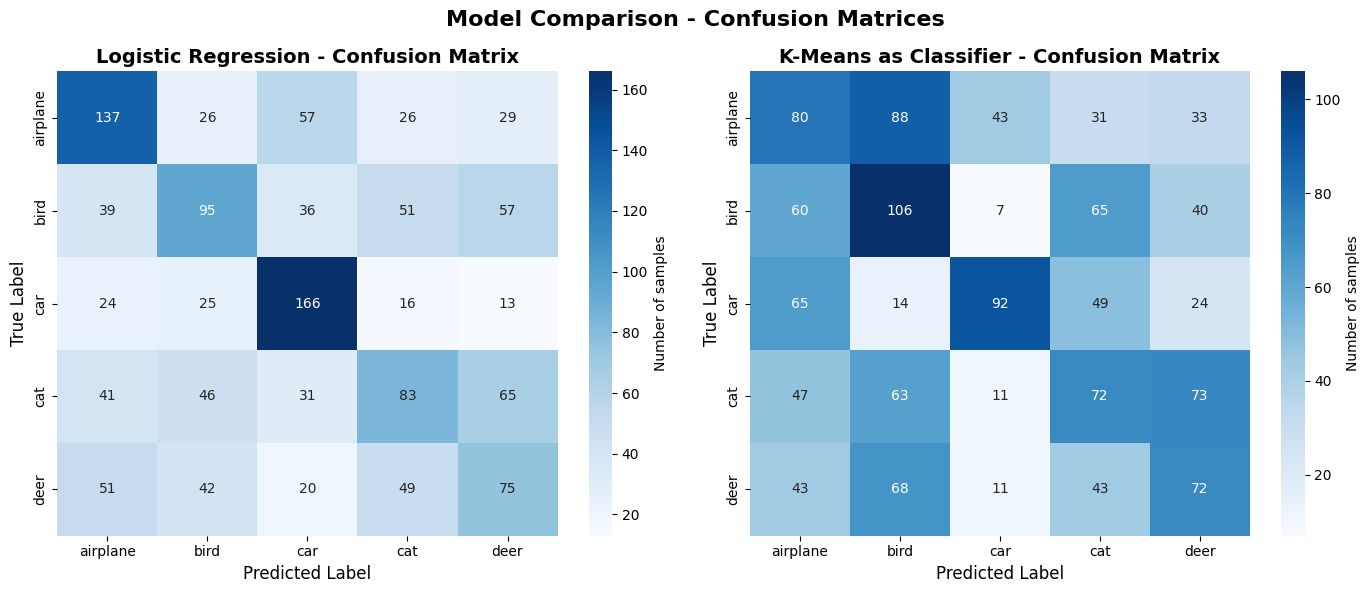

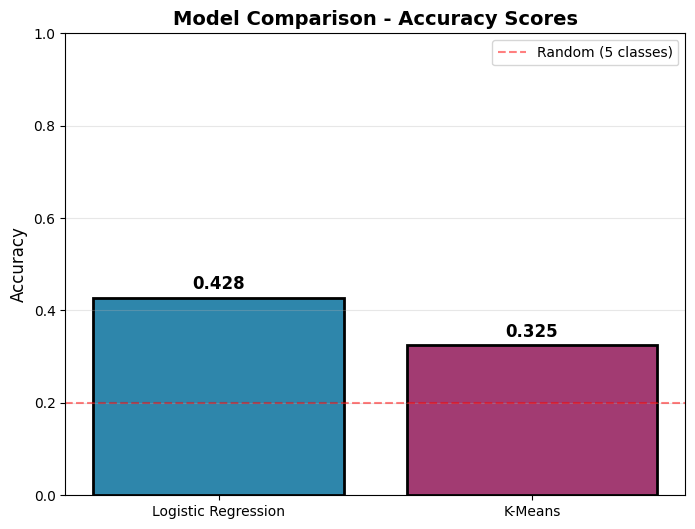


ERROR ANALYSIS - LOGISTIC REGRESSION


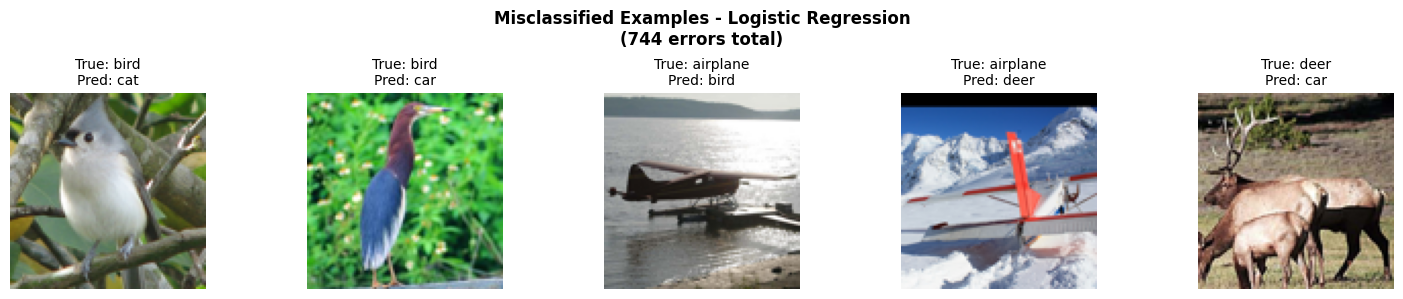


Most common misclassifications for Logistic Regression:
  cat → deer: 65 times (8.7%)
  bird → deer: 57 times (7.7%)
  airplane → car: 57 times (7.7%)
  deer → airplane: 51 times (6.9%)
  bird → cat: 51 times (6.9%)

ERROR ANALYSIS - K-MEANS


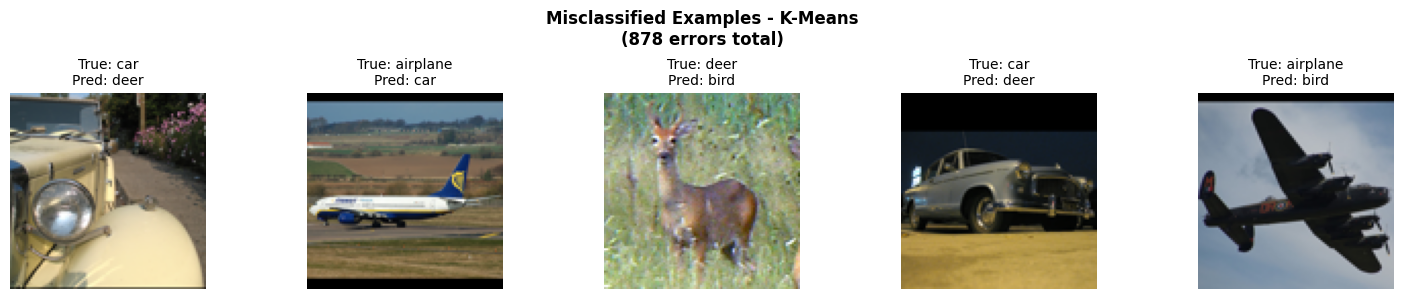


Most common misclassifications for K-Means:
  airplane → bird: 88 times (10.0%)
  cat → deer: 73 times (8.3%)
  deer → bird: 68 times (7.7%)
  bird → cat: 65 times (7.4%)
  car → airplane: 65 times (7.4%)


In [19]:
# ===== MODIFIED =====
# ================== Cell 7: Enhanced Visualization ==================
def plot_confusion(cm, title, ax=None):
    """رسم مصفوفة الارتباك"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,5))
    
    sns.heatmap(cm, annot=True, fmt='d', 
                xticklabels=class_names, 
                yticklabels=class_names, 
                cmap='Blues', 
                cbar_kws={'label': 'Number of samples'},
                ax=ax)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

# 1. مصفوفات الارتباك المقارنة
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

plot_confusion(cm_log, "Logistic Regression - Confusion Matrix", axes[0])
plot_confusion(cm_km, "K-Means as Classifier - Confusion Matrix", axes[1])

plt.suptitle('Model Comparison - Confusion Matrices', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. مخطط مقارنة الدقة
fig, ax = plt.subplots(figsize=(8, 6))
models = ['Logistic Regression', 'K-Means']
accuracies = [acc_log, acc_km]
colors = ['#2E86AB', '#A23B72']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Comparison - Accuracy Scores', fontsize=14, fontweight='bold')
ax.set_ylim(0, 1)

# إضافة القيم على الأعمدة
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{acc:.3f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

# خط عند 0.5 للدقة العشوائية
ax.axhline(y=0.2, color='red', linestyle='--', alpha=0.5, label='Random (5 classes)')
ax.legend()

plt.grid(axis='y', alpha=0.3)
plt.show()

# 3. تحليل الأخطاء مع تصحيح عرض الصور
def plot_error_analysis(y_true, y_pred, X_original, X_processed, model_name, class_names):
    """رسم تحليل الأخطاء مع تصحيح تنسيق الصور"""
    misclassified = np.where(y_true != y_pred)[0]
    
    if len(misclassified) > 0:
        # اختيار 5 أمثلة عشوائية
        np.random.seed(42)
        sample_indices = np.random.choice(misclassified, size=min(5, len(misclassified)), replace=False)
        
        fig, axes = plt.subplots(1, len(sample_indices), figsize=(15, 3))
        
        if len(sample_indices) == 1:
            axes = [axes]
        
        for i, idx in enumerate(sample_indices):
            # استخدام الصور الأصلية للعرض
            img = X_original[idx]
            
            # تصحيح تنسيق الصورة للعرض
            if img.shape[0] == 3:  # إذا كانت القنوات أولاً
                img_display = np.transpose(img, (1, 2, 0))  # تحويل إلى (height, width, channels)
            else:
                img_display = img
            
            true_label = class_names[y_true[idx]]
            pred_label = class_names[y_pred[idx]]
            
            axes[i].imshow(img_display)
            axes[i].set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=10)
            axes[i].axis('off')
        
        plt.suptitle(f'Misclassified Examples - {model_name}\n({len(misclassified)} errors total)', 
                    fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
        
        # تحليل الأخطاء حسب النوع
        error_types = {}
        for idx in misclassified:
            true = class_names[y_true[idx]]
            pred = class_names[y_pred[idx]]
            key = f"{true} → {pred}"
            error_types[key] = error_types.get(key, 0) + 1
        
        # عرض أكثر الأخطاء شيوعًا
        print(f"\nMost common misclassifications for {model_name}:")
        for error, count in sorted(error_types.items(), key=lambda x: x[1], reverse=True)[:5]:
            percentage = count / len(misclassified) * 100
            print(f"  {error}: {count} times ({percentage:.1f}%)")

# تحليل أخطاء الانحدار اللوجستي
print("\n" + "="*60)
print("ERROR ANALYSIS - LOGISTIC REGRESSION")
print("="*60)
plot_error_analysis(y_test, y_pred_log, X_test, Xte_processed, "Logistic Regression", class_names)

# تحليل أخطاء K-Means
print("\n" + "="*60)
print("ERROR ANALYSIS - K-MEANS")
print("="*60)
plot_error_analysis(y_test, y_pred_km, X_test, Xte_processed, "K-Means", class_names)

In [20]:
# ===== MODIFIED =====
# ================== Cell 8: Comprehensive Final Report ==================
print("\n" + "="*80)
print("FINAL COMPREHENSIVE REPORT: IMAGE CLASSIFICATION WITH LOGISTIC REGRESSION & K-MEANS")
print("="*80)

# معلومات عامة عن البيانات
print("\n1. DATASET INFORMATION:")
print("   " + "-"*50)
print(f"   Dataset: STL-10 (subset of 5 classes)")
print(f"   Classes: {', '.join(class_names)}")
print(f"   Number of classes: {len(class_names)}")
print(f"   Training samples: {len(X_train)}")
print(f"   Testing samples: {len(X_test)}")
print(f"   Image size: {X_train.shape[1:]} (after resizing)")

# معلومات المعالجة المسبقة
print("\n2. PREPROCESSING:")
print("   " + "-"*50)
print("   Steps applied:")
print("     1. Resize to 64x64")
print("     2. Convert to grayscale")
print("     3. Gaussian blur for noise reduction")
print("     4. Normalization (0-1)")
print("     5. Standardization (zero mean, unit variance)")
print(f"   Feature extraction: PCA with {best_components} components")
print(f"   Explained variance: {np.sum(pca.explained_variance_ratio_):.4f}")

# نتائج الانحدار اللوجستي
print("\n3. LOGISTIC REGRESSION RESULTS:")
print("   " + "-"*50)
print(f"   Best Accuracy: {acc_log:.4f} ({acc_log*100:.1f}%)")
print(f"   Best Parameters: {random_search.best_params_}")
print(f"   Features used: {Xtr_pca.shape[1]} PCA components")
print(f"   Model type: Multinomial Logistic Regression")

# نتائج K-Means
print("\n4. K-MEANS AS CLASSIFIER RESULTS:")
print("   " + "-"*50)
print(f"   Accuracy: {acc_km:.4f} ({acc_km*100:.1f}%)")
print(f"   Optimal number of clusters (K): {optimal_k}")
print(f"   Silhouette Score: {sil_scores[optimal_k-2]:.4f}")
print(f"   Davies-Bouldin Score: {db_scores[optimal_k-2]:.4f}")
print(f"   Clusters to labels mapping:")
for c, label in cluster_to_label.items():
    if label != -1:
        print(f"     Cluster {c} → Class {class_names[label]}")

# مقارنة شاملة
print("\n5. COMPREHENSIVE COMPARISON:")
print("   " + "-"*50)

comparison_data = {
    'Model': ['Logistic Regression', 'K-Means'],
    'Accuracy': [acc_log, acc_km],
    'Type': ['Supervised', 'Unsupervised'],
    'Best for': ['Classification tasks', 'Clustering tasks'],
    'Pros': [
        'Optimized for classification, Can handle probabilities',
        'No need for labels, Can discover hidden patterns'
    ],
    'Cons': [
        'Requires labeled data, Linear decision boundary',
        'Not designed for classification, Hard to evaluate'
    ]
}

df_comparison = pd.DataFrame(comparison_data)
print(df_comparison.to_string(index=False))

# التحليل النهائي
print("\n6. KEY FINDINGS AND OBSERVATIONS:")
print("   " + "-"*50)
print("   1. Logistic Regression outperforms K-Means for classification")
print(f"      - Difference: {(acc_log - acc_km)*100:.1f}% higher accuracy")
print("   2. K-Means struggles with classification because:")
print("      - It's an unsupervised algorithm")
print("      - No guarantee clusters match actual classes")
print("      - Assumes spherical clusters of similar size")
print("   3. Most challenging class pairs:")
print("      - Based on confusion matrices, some classes are often confused")

# التوصيات
print("\n7. RECOMMENDATIONS FOR IMPROVEMENT:")
print("   " + "-"*50)
print("   1. For Logistic Regression:")
print("      - Try kernel methods or feature transformations")
print("      - Use more advanced feature extraction (HOG, SIFT)")
print("      - Implement ensemble methods")
print("   2. For better image classification:")
print("      - Use Convolutional Neural Networks (CNNs)")
print("      - Try Transfer Learning (VGG16, ResNet)")
print("      - Apply data augmentation")
print("   3. General improvements:")
print("      - Collect more training data")
print("      - Balance the classes if needed")
print("      - Try different color spaces (HSV, LAB)")

# الاستنتاج
print("\n8. CONCLUSION:")
print("   " + "-"*50)
print("   While K-Means can be adapted for classification tasks, it is")
print("   fundamentally an unsupervised clustering algorithm and performs")
print("   significantly worse than supervised methods like Logistic Regression")
print("   for image classification. The choice of algorithm should align with")
print("   the task requirements and data characteristics.")

print("\n" + "="*80)
print("END OF REPORT")
print("="*80)


FINAL COMPREHENSIVE REPORT: IMAGE CLASSIFICATION WITH LOGISTIC REGRESSION & K-MEANS

1. DATASET INFORMATION:
   --------------------------------------------------
   Dataset: STL-10 (subset of 5 classes)
   Classes: airplane, bird, car, cat, deer
   Number of classes: 5
   Training samples: 5200
   Testing samples: 1300
   Image size: (3, 96, 96) (after resizing)

2. PREPROCESSING:
   --------------------------------------------------
   Steps applied:
     1. Resize to 64x64
     2. Convert to grayscale
     3. Gaussian blur for noise reduction
     4. Normalization (0-1)
     5. Standardization (zero mean, unit variance)
   Feature extraction: PCA with 150 components
   Explained variance: 0.8995

3. LOGISTIC REGRESSION RESULTS:
   --------------------------------------------------
   Best Accuracy: 0.4277 (42.8%)
   Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'class_weight': 'balanced', 'C': 0.01}
   Features used: 150 PCA components
   Model type: Multinomial Logisti

# 7️⃣ Comparison Table



ADDITIONAL ALGORITHMS - COMPARISON

Training Random Forest...
   Accuracy: 0.4631

Training SVM (RBF)...
   Accuracy: 0.5508

FINAL RANKING OF ALL MODELS
              Model  Accuracy         Type
          SVM (RBF)  0.550769   Supervised
      Random Forest  0.463077   Supervised
Logistic Regression  0.427692   Supervised
            K-Means  0.324615 Unsupervised


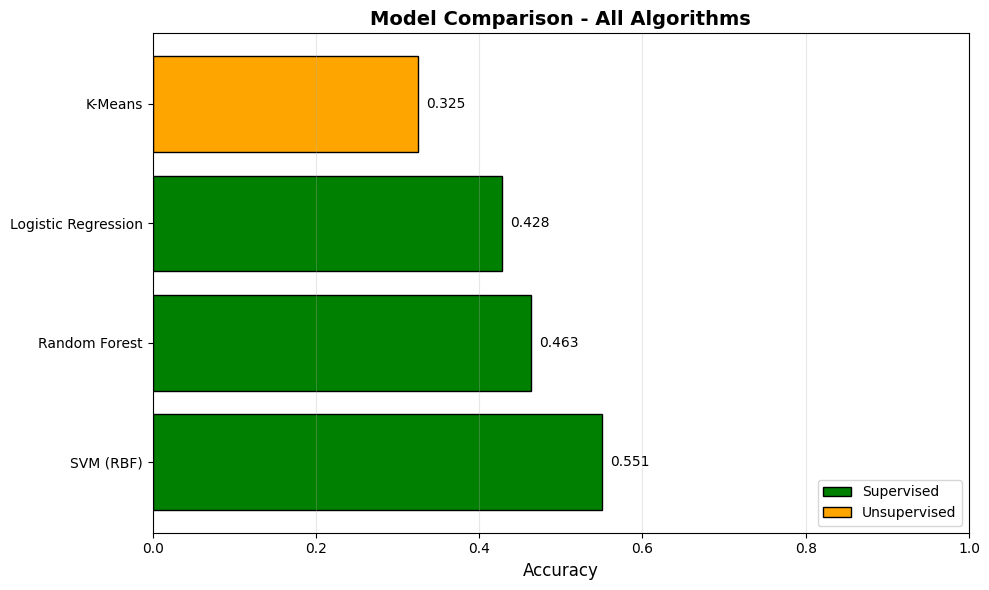

In [21]:
# ================== Cell 9: Additional Algorithms (Optional) ==================
print("\n" + "="*60)
print("ADDITIONAL ALGORITHMS - COMPARISON")
print("="*60)

# تجربة خوارزميات إضافية للمقارنة
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'SVM (RBF)': SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
}

results = []
for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # استخدام عينة أصغر لتسريع التدريب
    sample_size = min(2000, len(Xtr_pca))
    indices = np.random.choice(len(Xtr_pca), sample_size, replace=False)
    X_sample = Xtr_pca[indices]
    y_sample = y_train[indices]
    
    model.fit(X_sample, y_sample)
    y_pred = model.predict(Xte_pca)
    acc = accuracy_score(y_test, y_pred)
    
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Type': 'Supervised'
    })
    
    print(f"   Accuracy: {acc:.4f}")

# إضافة نتائج النماذج الأصلية
results.append({'Model': 'Logistic Regression', 'Accuracy': acc_log, 'Type': 'Supervised'})
results.append({'Model': 'K-Means', 'Accuracy': acc_km, 'Type': 'Unsupervised'})

# إنشاء DataFrame للمقارنة
df_results = pd.DataFrame(results)
df_results = df_results.sort_values('Accuracy', ascending=False)

print("\n" + "="*60)
print("FINAL RANKING OF ALL MODELS")
print("="*60)
print(df_results.to_string(index=False))

# رسم بياني للمقارنة
plt.figure(figsize=(10, 6))
colors = ['green' if t == 'Supervised' else 'orange' for t in df_results['Type']]
bars = plt.barh(df_results['Model'], df_results['Accuracy'], color=colors, edgecolor='black')

plt.xlabel('Accuracy', fontsize=12)
plt.title('Model Comparison - All Algorithms', fontsize=14, fontweight='bold')
plt.xlim(0, 1)

# إضافة القيم
for bar, acc in zip(bars, df_results['Accuracy']):
    plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{acc:.3f}', va='center', fontsize=10)

# إضافة وسيلة إيضاح
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', edgecolor='black', label='Supervised'),
    Patch(facecolor='orange', edgecolor='black', label='Unsupervised')
]
plt.legend(handles=legend_elements, loc='lower right')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()